In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist


Using TensorFlow backend.


### 1 Data generation

In [2]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_test.shape

(10000, 28, 28)

##### Utils functions generate Bags, consist of X zeros and 100-X sevens

In [3]:
def createBags(mnistImg,mnistLb,bag_num,shaffule=True,padding=0):
    zeros=mnistImg[mnistLb==0]
    sevens=mnistImg[mnistLb==7]
    print('zeros len',len(zeros),' sevens len ',len(sevens))
    max_size=(int)((len(zeros)+len(sevens))/200)
    if bag_num>max_size:
        bag_num=max_size
    print('bags_num : ',bag_num)
    X_rate=np.random.randint(1,100,size=bag_num)
    bags=np.zeros((bag_num,100,(28+2*padding),(28+2*padding)),dtype=np.uint8)
    itzer=0
    itsev=0
    for i in range(0,bag_num):
        for j in range(0,28):
            for k in range(0,28):
                bags[i,:X_rate[i],j+padding,k+padding]=zeros[itzer:itzer+X_rate[i],j,k]
                bags[i,X_rate[i]-100:,j+padding,k+padding]=sevens[itsev:itsev+100-X_rate[i],j,k]
        itzer+=X_rate[i]
        itsev+=100-X_rate[i]
    if shaffule:
        bags=np.random.default_rng().permutation(bags,axis=1)

    return bags,X_rate

def showBags(bags,size,index=0):
    canvas=np.zeros((size*10,size*10),dtype=np.uint8)
    for i in range(0,10):
        for j in range(0,10):
            canvas[i*size:i*size+size,j*size:j*size+size]=bags[index,i*10+j]
    return canvas

zeros len 5923  sevens len  6265
bags_num :  60
zero purity:  84


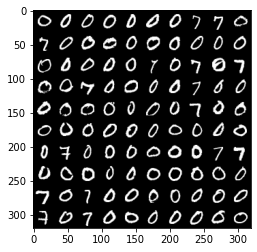

In [4]:
#train data
bags_train,label_train=createBags(x_train,y_train,100,shaffule=True,padding=2)
print('zero purity: ',label_train[5])
plt.imshow(showBags(bags_train,32,5),cmap='gray')

In [5]:
#test data
bags_test,label_test=createBags(x_test,y_test,100,shaffule=True,padding=2)

zeros len 980  sevens len  1028
bags_num :  10


### 2 Extract features & preprocess data

In [6]:
from keras.applications import resnet
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import keras

##### Use pretrained VGG16 net extract features

In [7]:
bags_train3=np.concatenate([np.expand_dims(bags_train, axis=-1)]*3,axis=-1)
bags_train3.astype('float32')
bags_train3=bags_train3/255
bags_train3.shape

(60, 100, 32, 32, 3)

#### keras pretrained VGGnet

In [8]:
featureExtractor=VGG16(weights='imagenet',include_top=False)

In [9]:
train_feature_data=[]
for bag in bags_train3:
    bag_features=featureExtractor.predict(preprocess_input(bag))
    train_feature_data.append(bag_features.reshape(100,512))
train_feature_data=np.array(train_feature_data)


In [10]:
bags_test3=np.concatenate([np.expand_dims(bags_test, axis=-1)]*3,axis=-1)
bags_test3.astype('float32')
bags_test3=bags_test3/255
test_feature_data=[]
for bag in bags_test3:
    bag_features=featureExtractor.predict(preprocess_input(bag))
    test_feature_data.append(bag_features.reshape(100,512))
test_feature_data=np.array(test_feature_data)

#### normalize y label : purity shape(none,1)

In [11]:
label_train.astype('float32')
label_train=label_train/100
label_test.astype('float32')
label_test=label_test/100
label_train=label_train.reshape(-1,1)
label_test=label_test.reshape(-1,1)

### 3 MIL Modeling

In [12]:
from keras.layers import Input,Subtract,Multiply, BatchNormalization, MaxPooling1D
from keras.layers.core import Dropout ,Flatten,Dense , Reshape , Lambda
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras.activations import relu
import math


#### sample point layer, used in Bag lever representation

In [13]:
def expandDims(x):
    x1=K.expand_dims(x,-1)
    return x1

class samplePoint(Layer):
    def __init__(self,num_instances,num_features,num_bins,**wkargs):
        self.num_instances=num_instances
        self.num_features=num_features
        self.num_bins=num_bins
        super(samplePoint,self).__init__()
        self.ouput_dim=(num_instances,num_features,num_bins)
        self.sample_point=np.linspace(0,1,num_bins,dtype=np.float32)
        self.sample_points=np.tile(self.sample_point,(num_instances,num_features,1))
    def build(self,input_shape):
        self.kernal=self.add_weight(name='sample_point',
                                    shape=(0,0),
                                    initializer='uniform',
                                    trainable=False
                                   )
        super(samplePoint,self).build(input_shape)
    def call(self,x):
        return Subtract()([x,K.constant([self.sample_points])])
    def compute_output_shape(self,input_shape):
        return (input_shape[0],self.num_instances,self.num_features,self.num_bins)
    

In [14]:
def MILModel(num_instances=100,num_features=512,num_classes=1,num_bins=21,sigma=0.0167,batch_size=5):
    alfa = 1/math.sqrt(2*math.pi*(sigma**2))
    beta = -1/(2*(sigma**2))
    spLayer=samplePoint(num_instances,num_features,num_bins)
    
    
    
    X=Input(shape=(num_instances,num_features))

##-------------------- Distribution pooling filter---------------
    , num_instances, num_features = X.shape
    x=Lambda(expandDims)(X)
    

    #x=MaxPooling1D(pool_size=3)(x)
    diff=spLayer(x)
    diff2=Lambda(lambda x :x**2)(diff)
    
    exp=Lambda(lambda x:K.exp(x))
    cox=Lambda(lambda x:x*beta)
    result=cox(exp(diff2))

    out_unnormalized = Lambda(lambda x:K.sum(x,axis=1))(result)
    norm_coeff = Lambda(lambda x:K.sum(x, axis=2, keepdims=True))(out_unnormalized)
    out=Multiply()([out_unnormalized,Lambda(lambda x:1/x)(norm_coeff)])

##----------------------Representation transform
    out=MaxPooling1D(3,2)(out)
    x=Flatten()(out)
    
    x=Dense(384,activation='relu')(x)
    x=BatchNormalization()(x)
    x=Dense(192)(x)
    x=Dense(192,use_bias=True)(x)
    out1=Dense(num_classes)(x)
    
    
    model=Model(inputs=[X],outputs=out1)
    return model

In [15]:
Mil_model=MILModel(num_classes=1)

In [16]:
Mil_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 512)     0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 100, 512, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
sample_point_1 (samplePoint)    (None, 100, 512, 21) 0           lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 100, 512, 21) 0           sample_point_1[0][0]             
____________________________________________________________________________________________

### 4 Trainning 

In [17]:
from keras.optimizers import Adam,SGD
from keras import losses

In [18]:
def myloss(y_true, y_pred):
    loss1 =losses.mean_absolute_error(y_true, y_pred)
    return loss1

In [19]:
Mil_model.compile(optimizer=SGD(0.01),
                    loss=myloss)


In [20]:
history=Mil_model.fit(train_feature_data,label_train,epochs=200,batch_size=10,verbose=0)

In [21]:
Mil_model.save('MIL200_10.h5')

### 5 Evaluating

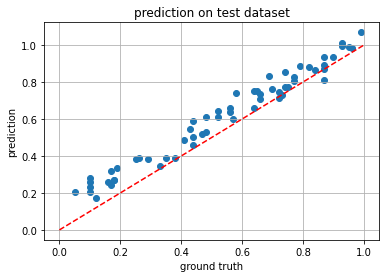

In [22]:
y_scatter=Mil_model.predict(train_feature_data)
line=np.linspace(0,1,20)
plt.ylabel('prediction')
plt.xlabel('ground truth')
plt.scatter(label_train,y_scatter)
plt.plot(line,line,color='r',linestyle='--')
plt.title("prediction on test dataset")
plt.grid()

In [23]:
print('loss on test ',Mil_model.evaluate(test_feature_data,label_test))
print('loss on train ',Mil_model.evaluate(train_feature_data,label_train))

10/10 [==============================] - 0s 4ms/step
loss on test  0.08194070309400558
60/60 [==============================] - 0s 416us/step
loss on train  0.07673474897940953


#### loss plot

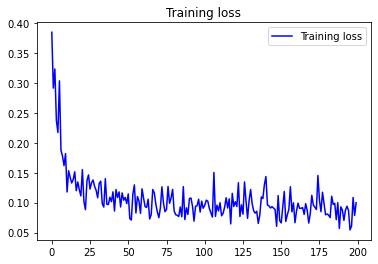

In [25]:
epochs=range(len(history.history['loss']))
plt.plot(epochs,history.history['loss'],'b',label='Training loss')
plt.title('Training loss')
plt.legend()

### 6 reference

[1]https://github.com/onermustafaumit/SRTPMs
[2]https://medium.com/swlh/multiple-instance-learning-c49bd21f5620
[3]https://www.p-chao.com/2017-01-19/%E7%9B%AE%E6%A0%87%E8%B7%9F%E8%B8%AA%EF%BC%88%E4%B8%80%EF%BC%89%E5%A4%9A%E5%AE%9E%E4%BE%8B%E5%9C%A8%E7%BA%BF%E5%AD%A6%E4%B9%A0/